In [1]:
"""Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced set among the best selected features
---- Training of ML Classifiers
-> Several MLP Classifiers are trained for all combinations of selected featuresets-datasets
---- Results
-> Stats of classification results are kept inside each .npz along with the respective trained model
"""
print(__doc__)
import time
start_time = time.time()
from copy import deepcopy, copy
import math
import scipy.io as sio
import shutil
import os, errno
from random import shuffle
import numpy as np
from pylab import *
from featext import *
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import re
import datetime
import urllib
import tarfile
import joblib
from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools

def _pickle_method(m):
    """Useful function for successful convertion from directories and lists to numpy arrays"""
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copy_reg.pickle(types.MethodType, _pickle_method)

def ensure_dir(directory):
    """Useful function for creating directory only if not existent"""
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
h = .2  # step size in the mesh

######## TRAINING DEFAULTS
cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
names = ["NearNb", "RBFSVM1", "MLP1", "RandFor"]
classifiers = [KNeighborsClassifier(5),
               SVC(gamma='auto', C=1),
               MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]

download = 1 # Download pre-computed (1) data or compute them all anew (0)

Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced 

In [2]:
############ INITIALISATION PARAMETERS ############
window, shift = 1024, 20
samplesperdataset = 10000
havelabel = 1
returntime = 0
featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format, 
featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
featparam = [havelabel,featlabel,magnFFT,featall,returntime]
CV = 5                # cross validation checks
numfeat = 10          # number of features to show
nfeat = 1000          # number of features to keep
###### Initialize necessary names and paths
datapath = 'data/'
ensure_dir(datapath)
datafile = datapath+'dataset.npz'
validfile = datapath+'validation.mat'
featpath = datapath+'features/'+str(window)+'_'+str(shift)+'/'
ensure_dir(featpath)
prefeatname = 'prefeatures'+'_'+str(window)+'_'+str(shift)+'_'+str(samplesperdataset)
prefeatfile = featpath+prefeatname+'.npz'
featname = 'features'+'_'+str(window)+'_'+str(shift)+'_'+str(samplesperdataset)
featfile = featpath+featname+'.npz'
validfeatname = 'valid'+featname
validfeatfile = featpath+validfeatname+'.npz'
surffile = featpath+featname+'_2fing_6surf.npz'
XYfile = featpath+featname+'_XY.npz'
XYsplitfile = featpath+featname+'_XYsplit.npz'
validsurffile = featpath+validfeatname+'_2fing_6surf.npz'
validXYfile = featpath+validfeatname+'_XY.npz'
validXYsplitfile = featpath+validfeatname+'_XYsplit.npz'
respath = datapath+'results'

In [3]:
############ Feature Names ############
"""features:                                                                       ||      if       
   |--> time domain      :                                                         || samples = 1024
   |----|---> phinyomark : 11+3{shist} --------------------------> = 14+0.0samples ||             14
   |----|---> golz       : 10+samples{acrol} --------------------> = 10+1.0samples ||           1034
   |--> frequency domain :                                                                          
   |----|---> phinyomark : 3{arco}+4{mf}+2(samples/2+1){RF,IF} --> =  9+1.0samples ||           1033
   |----|---> golz       : 2(samples/2+1){AF,PF} ----------------> =  2+1.0samples ||           1026
   |----|----------------|-------alltogether---------------------> = 35+3.0samples || numfeat = 3107
"""
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}

In [4]:
############ Download necessary files ############
def download_file(datafile, targetlink):
    """Function for checking if targetfile exists, else downloading it from targetlink to targetpath+targetfile"""
    if not os.path.isfile(datafile):
        print 'Necessary ', datafile, ' not here! Downloading...'
        u = urllib.urlopen(targetlink)
        data = u.read()
        print 'Completed downloading ','{:.2f}'.format(len(data)*1./(1024**2)),'MB of ',datafile,'!'
        u.close()
        with open(datafile, "wb") as f :
            f.write(data)
        print 'Necessary ', datafile, ' completed saving!'
    else:
        print 'Necessary ', datafile, ' already here!'

def extract_file(zipfile):
    
    return unzipfile
        
####### Download necessary dataset
datafile = datapath+'dataset.npz'
validfile = datapath+'validation.mat'
datalink = 'https://www.dropbox.com/s/j88wmtx1vvpik1m/dataset.npz?dl=1'
validlink = 'https://www.dropbox.com/s/r8jl57lij28ljrw/validation.mat?dl=1'
download_file(datafile, datalink)
download_file(validfile, validlink)
####### Download features, if not wanting to compute them and not already there
if download==1:
    featlink = 'https://www.dropbox.com/s/qvk9pcvlir06zse/features_1024_20_10000.npz?dl=1'
    validfeatlink = 'https://www.dropbox.com/s/sghqwifo8rxwbcs/validfeatures_1024_20_10000.npz?dl=1'
    download_file(featfile, featlink)
    download_file(validfeatfile, validfeatlink)

Necessary  data/dataset.npz  already here!
Necessary  data/validation.mat  already here!
Necessary  data/features/1024_20/features_1024_20_10000.npz  already here!
Necessary  data/features/1024_20/validfeatures_1024_20_10000.npz  already here!


In [5]:
############ READ THE DATASET ############
def data_prep(datafile,step=1,k=2):
    """Prepare dataset, from each of the k fingers for all n surfaces (see fd for details)
    -> datafile : input file either in .npz or in .mat form
    -> step     : increasing sampling step, decreases sampling frequency of input, which is 1KHz initially
    -> k        : number of fingers logging data
    ----- input format ----- either 'fi', 'li', 'fdi', with i in {1,...,k} for each finger
                             or     'f', 'l', 'fd' for a finger
                             corresponding to force, label and details respectively
    <- f,l,fd   : output force, label and details for each experiment in the dataset
    <- member   : how much each dataset is represented, 
                  to skip samples effectively and keep dimensions correct
    <- m1, m2   : portion of data belonging to finger1 and finger2
    """
    print "---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------"
    if datafile[-3:]=='mat':
        inp = sio.loadmat(datafile,struct_as_record=True)
    elif datafile[-3:]=='npz':
        inp = np.load(datafile)
    else:
        print "Unsupported input file format. Supported types: .npz .mat"
        return -1
    if k==2:
        f1, f2, l1, l2, fd1, fd2 = inp['f1'], inp['f2'], inp['l1'], inp['l2'], inp['fd1'], inp['fd2']
        print 1, '-> f1:', f1.shape, l1.shape, fd1.shape
        print 2, '-> f2:', f2.shape, l2.shape, fd2.shape
        ####### MERGE THE DATASETS
        f = np.concatenate((f1,f2),axis=0)
        l = np.concatenate((l1,l2),axis=0)
        fd = np.concatenate((fd2,fd2),axis=0)
    elif k==1:
        f, l, fd = inp['f'], inp['l'], inp['fd']
    else:
        print "Unsupported number of fingers k. Should be k in {1,2}"
    print 3, '-> f:', f.shape, l.shape, fd.shape
    # membership of each sample, representing its portion in the dataset 
    # (first half finger1 and second half finger2)
    member = np.zeros(len(f))
    m1,m2 = len(f)/2, len(f)/2
    member[:m1] = np.ones(m1)*1./m1
    member[-m2:] = np.ones(m2)*1./m2
    print 4, '-> m1,m2:', m1, m2, sum(member[:m1]), sum(member[-m2:])
    ####### MERGE f and l
    while f.ndim>1:
        f = f[:,0]
        l = l[:,0]
    for i in range(len(f)):
        while l[i].ndim<2:
            l[i] = l[i][:,np.newaxis]
    f = np.array([np.concatenate((f[i],l[i]),axis=1) for i in range(len(f))])
    print 5, '-> f=f+l:', f.shape, ":", [fi.shape for fi in f]
    ####### SUBSAMPLING
    # step = 1 # NO SAMPLING
    if step!=1:
        f = np.array([fi[::step,:] for fi in f])
        print 6, '-> fsampled:',f.shape, ":", [fi.shape for fi in f]
    return f,l,fd,member,m1,m2

In [6]:
############ PRE-FEATURES ############
###### DEFINITION
# featnum 0 : sf    = (fx^2+fy^2+fz^2)^0.5
#         1 : ft    = (fx^2+fy^2)^0.5
#         2 : fn    = |fz|
#         3 : ft/fn = (fx^2+fy^2)^0.5/|fz|
# input (nxm) -> keep (nx3) -> compute pre-feature and return (nx1)

def sf(f):
    """Computation of norm (sf) of force (f)"""
    return np.power(np.sum(np.power(f[:,:3],2),axis=1),0.5)
def ft(f):
    """Computation of tangential (ft) of force (f)"""
    return np.power(np.sum(np.power(f[:,:2],2),axis=1),0.5)
def fn(f):
    """Computation of normal (fn) of force (f)"""
    return np.abs(f[:,2])
def ftn(f):
    """Computation of tangential (ft) to normal (fn) ratio of force (f), 
    corresponding to the friction cone boundary
    """
    retft = ft(f)
    retfn = fn(f)
    retft[retfn<=1e-2] = 0
    return np.divide(retft,retfn+np.finfo(float).eps)
def lab(f):
    """Label embedded in input f"""
    return np.abs(f[:,-1])
###### COMPUTATION
prefeatfn = np.array([sf,ft,fn,ftn,lab]) # convert to np.array to be easily indexed by a list
prefeatnames = np.array(['fnorm','ft','fn','ftdivfn','label'])
prefeatid = [0,4]     # only the prefeatures with corresponding ids will be computed
def compute_prefeat(f):
    """Prefeature computation
    -> f       : input force as an i by n by 4 matrix
    <- prefeat : corresponding force profiles
    """
    print "--------------------------------------- COMPUTING PREFEATURES ----------------------------------------"
    prefeat = [np.array([prfn(f[i]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))]
    prefeat.append(prefeat[-1][:-1])
    prefeat = np.array(prefeat)[:-1]
    print prefeat.shape,":",[p.shape for p in prefeat]
    return prefeat

In [7]:
############ AVG Computation time of ALL features in secs ############
def avg_feat_comp_time(prefeat):
    """Average computation time for feature extraction
    -> prefeat : desired prefeature input
    """
    print "------------------------------------ AVG FEATURE COMPUTATION TIME ------------------------------------"
    t1 = time.time()
    m = int(ceil(0.2*len(prefeat)))
    # avg over m*100 times
    tmpfeat = [feat(prefeat[k][i:i+window,:2],*featparam) for k in range(m) for i in range(100)]
    print 'Avg feature computation time (millisec): ', (time.time() - t1) / (100 * m) * 1000

In [8]:
############ FEATURE COMPUTATION ############
def tmpfeatfilename(p,name,mode='all'):
    """Filename for feature computation and intermittent saving
    -> p    : prefeat id
    -> name : desired prefix name for tmp filenames
    -> mode : whether keeping whole feature matrix ('all') or sampling rows ('red') to reduce size
    <- corresponding output filename
    """
    allfeatpath = featpath+'AllFeatures/'
    ensure_dir(allfeatpath)
    if mode == 'all':
        return allfeatpath+name+str(p)+'.pkl.z'
    elif mode == 'red':
        return allfeatpath+name+str(p)+'_red'+str(samplesperdataset)+'.pkl.z'
    
def feature_extraction(prefeat, member, featfile=featfile, name='feat_'):
    """Computation of all features in parallel or loading if already computed
    -> prefeat          : computed prefeatures
    -> member           : how much each dataset is represented, 
                          to skip samples effectively and keep dimensions correct
    -> featfile         : desired final feature filename             
    -> name             : desired per dataset feature temporary filenames
    <- features, labels : computed features and corresponding labels
    """
    print "---------------------------------------- FEATURE EXTRACTION ------------------------------------------"
    if os.path.isfile(featfile):
        start_time = time.time()
        features = np.load(featfile)['features']
        labels = np.load(featfile)['labels']
        print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
    else:
        start_time = time.time()
        features = []
        labels = []
        for ixp in range(len(prefeat)):
            p = prefeat[ixp]
            now = time.time()
            tmpfn = tmpfeatfilename(ixp,name)
            tmpfnred = tmpfeatfilename(ixp,name,'red')
            if not os.path.isfile(tmpfnred):
                if not os.path.isfile(tmpfn):
                    # Computation of all features in PARALLEL by ALL cores
                    tmp = np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) 
                                                         for k in range(0,len(p)-window,shift)])])
                    with open(tmpfn,'wb') as fo:
                        joblib.dump(tmp,fo)
                    print 'sample:', ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfn \
                                                        , ' computing... ', tmp.shape
                else:
                    with open(tmpfn,'rb') as fo:
                        tmp = joblib.load(fo)
                    print 'sample:', ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfn \
                                                        , ' already here!', tmp.shape
                # keep less from each feature vector but keep number of samples for each dataset almost equal
                tmpskip = int(round(tmp.shape[1]/(member[ixp]*samplesperdataset)))
                if tmpskip == 0: 
                    tmpskip = 1
                # Save reduced size features
                tmp = tmp[0,::tmpskip,:,:]
                with open(tmpfnred,'wb') as fo:
                    joblib.dump(tmp,fo)
                print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfnred, tmp.shape
        for ixp in range(len(prefeat)):  
            tmpfnred = tmpfeatfilename(ixp,name,'red')
            with open(tmpfnred,'rb') as fo:
                tmp = joblib.load(fo)
            print 'sample:', ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfnred, 'already here!' \
                                                                                  , tmp.shape
            features.append(tmp[:,:,:-1])
            labels.append(tmp[:,0,-1])
        print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s sec " % (time.time() - start_time))
        features.append(tmp[:-1,:,:-1])
        features = np.array(features)[:-1]
        labels.append(tmp[:-1,0,-1])
        labels = np.array(labels)[:-1]
        print 'features: ',features.shape,[ftmp.shape for ftmp in features]
        print 'labels: ', labels.shape,[l.shape for l in labels]
        np.savez(featfile,features=features,labels=labels)
    print 'features: ', features.shape, ', labels: ', labels.shape
    return features, labels

In [9]:
############ LABEL TRIMMING ############
def label_cleaning(prefeat,labels,member,history=500):
    """Keep the purely stable and slip parts of label, thus omitting some samples around sign change points
    -> prefeat    : computed prefeatures
    -> labels     : main structure, where the trimming will be performed around change points
    -> member     : how much each dataset is represented, to skip samples effectively and keep dimensions correct
    -> history    : how much samples to throw away around change points
    <- new_labels : the trimmed labels
    """
    print "----------- KEEPING LABEL's PURE (STABLE, SLIP) PHASE PARTS (TRIMMING AROUND CHANGE POINTS)-----------"
    lbl_approx = []
    for i in range(len(prefeat)):
        tmpd = np.abs(np.diff(prefeat[i][:,-1].astype(int),n=1,axis=0))
        if np.sum(tmpd) > 0:
            tmpind = np.array(range(len(tmpd)))[tmpd > 0]   # find the sign change points
            tmpindrng = []
            for j in range(len(tmpind)):
                length = history                # keep/throw a portion of the signal's length around change points
                tmprng = np.array(range(tmpind[j]-length,tmpind[j]+length))
                tmprng = tmprng[tmprng>=0]      # make sure inside singal's x-range
                tmprng = tmprng[tmprng<prefeat[i].shape[0]]
                tmpindrng += tmprng.tolist()
            tmpindrng = np.array(tmpindrng).flatten()
            tmp_lbl = deepcopy(prefeat[i][:,-1])
            tmp_lbl[tmpindrng] = -1
            lbl_approx.append(tmp_lbl)
        else:
            lbl_approx.append(prefeat[i][:,-1])
    new_labels = deepcopy(labels)
    for ixp in range(len(lbl_approx)):
        p = lbl_approx[ixp]
        tmp = np.array([p[k+window] for k in range(0,len(p)-window,shift)])
        tmpskip = int(round(tmp.shape[0]/(member[ixp]*samplesperdataset)))
        if tmpskip == 0: 
            tmpskip = 1
        # Sampling appropriately
        tmp = tmp[::tmpskip]
        if len(tmp) > len(labels[ixp]):
            tmp = tmp[:-1]
        new_labels[ixp] = tmp
    print 'new_labels: ', new_labels.shape
    return new_labels

In [10]:
############ GATHERING into complete arrays ready for FITTING ############
def computeXY(features,labels,new_labels,m1,m2,XYfile=XYfile,XYsplitfile=XYsplitfile):
    """
    -> features       : computed features as input data
    -> labels         : corresponding labels
    -> new_labels     : labels trimmed around change point
    -> m1, m2         : portion of data belonging to finger1 and finger2
    -> XY[split]file  : desired output filenames
    <- X,Y,Yn,Xsp,Ysp : X corresponds to the data, Y the label, and *sp to the trimmed label's versions
    """
    print "----------------------------- COMPUTING X,Y for CLASSIFIERS' INPUT -----------------------------------"
    if os.path.isfile(XYfile) and os.path.isfile(XYsplitfile):
        X = np.load(XYfile)['X']
        Y = np.load(XYfile)['Y']
        Yn = np.load(XYfile)['Yn']
        Xsp = np.load(XYsplitfile)['X']
        Ysp = np.load(XYsplitfile)['Y']
        print("XY files FOUND PRECOMPUTED!")
    else:
        # gathering features X,Xsp and labels Y,Ysp,Yn into one array each
        ind,X,Xsp,Y,Ysp,Yn = {},{},{},{},{},{}
        ind[2] = range(features.shape[0])                                      # indeces for both fingers
        ind[0] = range(features.shape[0])[:m1]                                 # indeces for finger1
        ind[1] = range(features.shape[0])[-m2:]                                # indeces for finger2
        ind = np.array([i for _,i in ind.items()])                             # convert to array
        for k in range(len(ind)):
            X[k] = features[ind[k]]                                            # input feature matrix
            Y[k] = labels[ind[k]]                                              # output label vector
            Yn[k] = new_labels[ind[k]]                                         # output new_label vector
            print 'Before -> X[',k,']: ',X[k].shape,', Y[',k,']: ',Y[k].shape,', Yn[',k,']: ',Yn[k].shape
            X[k] = np.concatenate(X[k],axis=0)
            Y[k] = np.concatenate(Y[k],axis=0)
            Yn[k] = np.concatenate(Yn[k],axis=0)
            print 'Gathered -> X[',k,']: ',X[k].shape,', Y[',k,']: ',Y[k].shape,', Yn[',k,']: ',Yn[k].shape
            X[k] = np.array([X[k][:,:,i] for i in range(X[k].shape[2])])
            tmp_sampling = int(round(X[k].shape[1]*1./samplesperdataset))
            if tmp_sampling == 0:
                tmp_sampling = 1
            X[k] = X[k][0,::tmp_sampling,:]
            Y[k] = Y[k][::tmp_sampling]
            Yn[k] = Yn[k][::tmp_sampling]
            print 'Gathered, sampled to max ', samplesperdataset, ' -> X[', k,']: ', X[k].shape, ', Y[', k \
                                             , ']: ', Y[k].shape, ', Yn[', k,']: ', Yn[k].shape
            keepind = Yn[k]>=0
            Xsp[k] = X[k][keepind,:]
            Ysp[k] = Yn[k][keepind]
            print 'Split -> Xsp[',k,']: ',Xsp[k].shape,', Ysp[',k,']: ',Ysp[k].shape
        X = np.array([i for _,i in X.items()])
        Xsp = np.array([i for _,i in Xsp.items()])
        Y = np.array([i for _,i in Y.items()])
        Ysp = np.array([i for _,i in Ysp.items()])
        Yn = np.array([i for _,i in Yn.items()])
        np.savez(XYfile,X=X,Y=Y,Yn=Yn)
        np.savez(XYsplitfile, X=Xsp, Y=Ysp)
    print 'X,Y [0,1,2]: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape
    print 'Xsp,Ysp [0,1,2]: ', Xsp[0].shape, Ysp[0].shape, Xsp[1].shape, Ysp[1].shape, Xsp[2].shape, Ysp[2].shape
    return X,Y,Yn,Xsp,Ysp

In [11]:
############ Prepare the indeces for each feature ############
def get_feat_id(feat_ind, printit=0, sample_window=window): 
    """Find the corresponding indeces of the desired features inside feature vector,
    and link them with their names and level of abstraction
    -> feat_ind        : range of indeces
    -> printit         : print output indeces (1) or not (0)
    -> sample_window   : parameter for accurate computation of feature indeces
    <- full_path_id    : indeces of all features
    <- norm_time_feats : indeces of time features
    <- norm_freq_feats : indeces of frequency features
    """
    # get the feat inds wrt their source : 3rd level
    norm_time_phin = range(0,14)
    norm_freq_phin = range(norm_time_phin[-1] + 1, norm_time_phin[-1] + 9 + sample_window + 1)
    norm_time_golz = range(norm_freq_phin[-1] + 1, norm_freq_phin[-1] + 10 + sample_window + 1)
    norm_freq_golz = range(norm_time_golz[-1] + 1, norm_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    norm_time_feats = norm_time_phin + norm_time_golz
    norm_freq_feats = norm_freq_phin + norm_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    norm_feats = norm_time_feats + norm_freq_feats

    # get the feat inds wrt their source : 3rd level
    disp = norm_feats[-1]+1
    ftfn_time_phin = range(disp ,disp + 14)
    ftfn_freq_phin = range(ftfn_time_phin[-1] + 1, ftfn_time_phin[-1] + 9 + sample_window + 1)
    ftfn_time_golz = range(ftfn_freq_phin[-1] + 1, ftfn_freq_phin[-1] + 10 + sample_window + 1)
    ftfn_freq_golz = range(ftfn_time_golz[-1] + 1, ftfn_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    ftfn_time_feats = ftfn_time_phin + ftfn_time_golz
    ftfn_freq_feats = ftfn_freq_phin + ftfn_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    ftfn_feats = ftfn_time_feats + ftfn_freq_feats

    # create the final "reference dictionary"
    # 3 np.arrays, id_list[0] = level 1 etc
    id_list = [np.zeros((len(ftfn_feats + norm_feats),1)) for i in range(3)]
    id_list[0][:norm_feats[-1]+1] = 0 # 0 signifies norm / 1 signifies ft/fn
    id_list[0][norm_feats[-1]+1:] = 1

    id_list[1][:norm_time_phin[-1]+1] = 0 # 0 signifies time / 1 signifies freq
    id_list[1][norm_time_phin[-1]+1:norm_freq_phin[-1]+1] = 1
    id_list[1][norm_freq_phin[-1]+1:norm_time_golz[-1]+1] = 0
    id_list[1][norm_time_golz[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[1][norm_freq_golz[-1]+1:ftfn_time_phin[-1]+1] = 0
    id_list[1][ftfn_time_phin[-1]+1:ftfn_freq_phin[-1]+1] = 1
    id_list[1][ftfn_freq_phin[-1]+1:ftfn_time_golz[-1]+1] = 0
    id_list[1][ftfn_time_golz[-1]+1:] = 1

    id_list[2][:norm_freq_phin[-1]+1] = 0 #0 signifies phinyomark / 1 signifies golz
    id_list[2][norm_freq_phin[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[2][norm_freq_golz[-1]+1:ftfn_freq_phin[-1]+1] = 0
    id_list[2][ftfn_freq_phin[-1]+1:] = 1 
    
    full_path_id = [np.zeros((len(feat_ind),5)) for i in range(len(feat_ind))]
   
    for ind, val in enumerate(feat_ind):
        full_path_id[ind] = [val, id_list[2][val], id_list[1][val], id_list[0][val]]
        if (printit==1):
            if(full_path_id[ind][1]==0):
                lvl3 = 'Phin'
            else:
                lvl3 = 'Golz'
            if(full_path_id[ind][2]==0):
                lvl2 = 'Time'
            else:
                lvl2 = 'Freq'
            if(full_path_id[ind][3]==0):
                lvl1 = 'Norm'
            else:
                lvl1 = 'Ft/Fn'
            print(feat_ind[ind],featnames[val%(norm_feats[-1]+1)],lvl3,lvl2,lvl1)
    
    return(full_path_id,norm_time_feats,norm_freq_feats)        

In [12]:
############ Surface Splitting ############
def surface_split(data_X, data_Y, n=6, k=2):
    """Split input data in k*n equal slices which represent n different surfaces sampled from k fingers.
    Indexes 0:n:(k-1)*n, 1:n:(k-1)*n+1, 2:n:(k-1)*n+2, ... correspond to the same surface (finger1 upto fingerk)
    Assuming k=2, namely 2 fingers case, unless stated differently
    -> data_X, data_Y        : input data and labels, with the convention that data_X contains k*n almost 
                               equally sized data, where the n first are acquired from finger1 ... 
                               and the n last from fingerk. 
    -> n                     : number of different surfaces
    -> k                     : number of fingers logging data
    <- surfaces, surf_labels : corresponding output data and labels
    """
    keep = data_X.shape[0]-np.mod(data_X.shape[0],k*n)
    surfaces_pre = np.array(np.split(data_X[:keep,:],k*n))
    surf_labels_pre = np.array(np.split(data_Y[:keep],k*n))
    surfaces, surf_labels = {},{}
    for i in range(n):
        inds = range(i,k*n,n)
        surfaces[inds[0]] = np.concatenate((surfaces_pre[inds[0]], surfaces_pre[inds[1]]), axis = 0)
        surf_labels[inds[0]] = np.concatenate((surf_labels_pre[inds[0]], surf_labels_pre[inds[1]]), axis = 0)
    surfaces = np.array([i for _,i in surfaces.items()])
    surf_labels = np.array([i for _,i in surf_labels.items()])
    return surfaces, surf_labels

In [13]:
############ Featureset Splitting ############
subfeats = ['AFFT','FREQ','TIME','BOTH']
def feat_subsets(data,fs_ind,ofs=len(featnames)):
    """returns a splitting per featureset of input features
    -> data                                : input data X
    -> fs_ind                              : prefeature id
    -> ofs                                 : number of features in total
    <- X_amfft, X_freq_all, X_time, X_both : split featuresets amplitude of FFT, all time only,
                                                               all frequency only and all features
    """
    _,tf,ff = get_feat_id(range(ofs))
    amfft_inds = []
    temp1 = deepcopy(data)
    
    for i in range(len(featnames)):
        if (featnames[i].startswith('amFFT')):
            amfft_inds.append(i)

    if (fs_ind == 2):
        ff2 = [ff[i]+ofs for i in range(len(ff))]
        tf2 = [tf[i]+ofs for i in range(len(tf))]
        amfft2 = [amfft_inds[i]+ofs for i in range(len(amfft_inds))]
        freqf = ff2 + ff
        timef = tf2 + tf
        amfft = amfft_inds + amfft2
    else:
        freqf = ff
        timef = tf
        amfft = amfft_inds

    X_amfft = temp1[:,amfft]
    X_time = np.delete(temp1,freqf,axis=1)
    X_freq_all = np.delete(temp1,timef,axis=1)
    X_both = data
    return X_amfft, X_freq_all, X_time, X_both

In [14]:
############ Prepare the dataset split for each surface ############
def computeXY_persurf(Xsp,Ysp,surffile=surffile):
    """returns a split per surface data and label of inputs
    -> Xsp, Ysp     : input data and labels, after having trimmed data around the label's change points
    -> surffile     : desired output's filename for saving
    <- surf, surfla : output data and label, split per surface
    """
    print "------------------------ COMPUTING X,Y per surface CLASSIFIERS' INPUT --------------------------------"
    if os.path.isfile(surffile):
        surf = np.load(surffile)['surf']       # input array containing computed features for each surface
        surfla = np.load(surffile)['surfla']   # corresponding label
    else:
        surf, surfla = [], []
        for i in range(len(prefeatid)-1): # for each featureset (corresponding to each prefeature, here only |f|)
            surf1, surfla1 = surface_split(Xsp[2], Ysp[2])
            tmpsurf = deepcopy(surf1)
            tmpsurfla = deepcopy(surfla1)
            tmpsurfsubfeat = []
            for j in range(tmpsurf.shape[0]+1): # for each surface
                print i,j,surf1.shape
                if j == tmpsurf.shape[0]:
                    # ommit a sample for converting to array
                    tmpsurfsubfeat.append(feat_subsets(tmpsurf[j-1,:-1,:],i))
                else:
                    # keep all subfeaturesets
                    tmpsurfsubfeat.append(feat_subsets(tmpsurf[j],i))
            surf.append(tmpsurfsubfeat)
            surfla.append(surfla1)
        # surf dims: (featuresets, surfaces, prefeaturesets) with each one enclosing (samples, features)
        surf = np.array(surf).transpose()[:,:-1,:]
        # surfla dims: (samples, surfaces, prefeaturesets)
        surfla = np.array(surfla).transpose()
        np.savez(surffile,surf=surf,surfla=surfla)
    print surf.shape, surfla.shape
    return surf, surfla

In [15]:
############ PIPELINE OF TRANSFORMATIONS ############
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    """returns a pipeline of inputs: 
    -> scaler            : first normalize
    -> feature_selection : then perform feature selection
    -> decomp            : followed by PCA 
    -> clf               : and finally the desired classifier
    <- pipeline          : output pipeline
    """
    pipeline = Pipeline([('scaler', scaler),
                         ('feature_selection', feature_selection),
                         ('decomp', decomp),         
                         ('classifier', clf) ])
    return pipeline

In [16]:
def comb(n,r):
    """Combinations of n objects by r, namely picking r among n possible.
    comb(n,r) = n!/(r!(n-r)!)
    """
    return math.factorial(n)/(math.factorial(r)*math.factorial(n-r))

In [17]:
############ TRAINING with 1 surface each time, out of 6 surfaces in total ##############
def filename1(i,j,k,l,retpath=0):
    """function for the filename of the selected combination for training per 1 surface
    -> i : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> k : surface id trained on
    -> l : surface id tested on
    <- filename
    """
    filepath = respath+'1/'
    ensure_dir(filepath)
    if retpath:
        return filepath
    else:
        return filepath+'fs_'+str(i)+'_subfs_'+str(j)+'_tr_'+str(k)+'_ts_'+str(l)+'.npz'

def cross_fit1(i,j,k,kmax,l,data,labels,data2,labels2,pipe):
    """function for fitting model per 1 surface
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> k              : surface id trained on
    -> kmax           : maximum surfaces
    -> l              : surface id tested on
    -> data, labels   : training data and labels
    -> data2, labels2 : testing data and labels
    -> pipe           : the desired pipeline configuration
    <- no output, saved model and confusion matrix in corresponding filename.npz
    """
    fileid = filename1(i,j,k,l)
    if not os.path.isfile(fileid):
        print i,j,k,l
        if k==l: # perform K-fold cross-validation       
            folds = cv.split(data, labels)
            cm_all = np.zeros((2,2))
            for fold, (train_ind, test_ind) in enumerate(folds):
                x_train, x_test = data[train_ind], data[test_ind]
                y_train, y_test = labels[train_ind], labels[test_ind]
                model = pipe.fit(x_train,y_train)
                y_pred = model.predict(x_test)
                cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                cm_all += cm/5.
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            # Check if model already existent, but not the cross-validated one (on the same surface)
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename1(i,j,k,m)+'.npz'
                if k!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k)+', tested on '+str(m)+'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps1(i,j,jmax,surf,surfla):
    """function for helping parallelization of computations per 1 surface
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> jmax           : number of all subfeaturesets
    -> surf, surfla   : surface data and labels
    """
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k in range(surf.shape[0]): # for every training surface
        for l in range(surf.shape[0]): # for every testing surface
            cross_fit1(i,j,k,surf.shape[0],l,surf[k],surfla[:,k],surf[l],surfla[:,l],pipe)

def train_1_surface(surf,surfla,n=-1):
    """Parallel training -on surface level- of all combinations on 1 surface
    -> n              : number of cores to run in parallel, 
                        input of joblib's Parallel (n=-1 means all available cores)
    -> surf, surfla   : surface data and labels
    *** Cross surface validation, TRAINING with 1 surface each time, out of 6 surfaces in total
    total= 4 (featuresets) * [comb(6,1)*6] (surface combinations: trained on 1, tested on 1) * 1 (prefeatureset)
         = 4*6*6*1 = 144 different runs-files.
    Note that comb(n,r) = n!/(r!(n-r)!)
    """
    print "-------------------------- TRAINING all combinations per 1 surface -----------------------------------"
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps1) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                  for j in range(surf.shape[0])])]
        
def bargraph_file_gen1(maxsurf):
    prefeats = prefeatnames[prefeatid][:-1]
    # prefeatures, subfeatures, trained, tested, (TP,TN,FN,FP)
    acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,4))
    # prefeatures, subfeatures, trained, cross_val_self_accuracy, (TP,TN,FN,FP)
    self_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,1,4))
    # features, subfeatures, trained, (tested avg, tested std), (TP,TN,FN,FP)
    cross_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,2,4))    
    initial_str = """# clustered and stacked graph data
=stackcluster;TP;TN;FN;FP
colors=med_blue,dark_green,yellow,red
=nogridy
=noupperright
fontsz=3
legendx=right
legendy=center
datascale=50
yformat=%g%%
xlabel=TrainedON-TestedON
ylabel=Metrics
=table"""
    respath = filename1(_,_,_,_,1)
    for i in range(len(prefeats)):
        outname = respath+prefeats[i]
        outfile = outname+'.perf'
        outfile1 = outname+'_selfaccuracy.perf'
        outfile2 = outname+'_crossaccuracy.perf'
        out = open(outfile,'w+')
        out.write(initial_str+"\n")
        out1 = open(outfile1,'w+')
        out1.write(initial_str+"\n")
        out2 = open(outfile2,'w+')
        out2.write(initial_str+"\n")
        for k in range(maxsurf):
            for k2 in range(maxsurf):
                out.write("multimulti="+str(k)+"-"+str(k2)+"\n")
                for j in range(len(subfeats)):
                    fileid = filename1(i,j,k,k2)
                    tmp = np.load(fileid)['cm']
                    # print to outfile
                    acc[i,j,k,k2,0] = round(tmp[1,1],2) # TP
                    acc[i,j,k,k2,1] = round(tmp[0,0],2) # TN
                    acc[i,j,k,k2,2] = 1-round(tmp[1,1],2) # FN
                    acc[i,j,k,k2,3] = 1-round(tmp[0,0],2) # FP
                    out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],acc[i,j,k,k2,0],acc[i,j,k,k2,1],
                                                                        acc[i,j,k,k2,2],acc[i,j,k,k2,3]))
                    # prepare and print to outfile1
                    if k == k2:
                        if j == 0:
                            out1.write("multimulti="+str(k)+"-"+str(k2)+"\n")
                        self_acc[i,j,k,0,:] = acc[i,j,k,k2,:]
                        out1.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],self_acc[i,j,k,0,0],
                                                                 self_acc[i,j,k,0,1],self_acc[i,j,k,0,2],
                                                                 self_acc[i,j,k,0,3]))
                    # prepare and print to outfile2
                    if k != k2:
                        # all values of corresponding subfeatureset j have been filled to compute avg and std
                        if (k < maxsurf-1 and k2 == maxsurf-1) or (k == maxsurf-1 and k2 == maxsurf-2):
                            if j == 0:
                                out2.write("multimulti="+str(k)+"\n")
                            t = range(maxsurf)
                            t.remove(k)
                            cross_acc[i,j,k,0,:] = np.mean(acc[i,j,k,t,:], axis=0) # avg
                            # cross_acc[i,j,k,1,:] = np.std(acc[i,j,k,t,:], axis=0) # std
                            out2.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j], cross_acc[i,j,k,0,0],
                                                                     cross_acc[i,j,k,0,1], cross_acc[i,j,k,0,2],
                                                                     cross_acc[i,j,k,0,3]))
        out.write("multimulti=AVG\n")
        out1.write("multimulti=AVG\n")
        out2.write("multimulti=AVG\n")
        for j in range(4):
            avgacc = np.mean(np.mean(acc[i,j,:,:,:], axis=0), axis=0)
            out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j], avgacc[0], avgacc[1], avgacc[2], avgacc[3]))
            avgselfacc = np.mean(self_acc[i,j,:,0,:], axis=0)
            out1.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j], avgselfacc[0], avgselfacc[1],
                                                                  avgselfacc[2], avgselfacc[3]))
            avgcrossacc0 = np.mean(cross_acc[i,j,:,0,:], axis=0)
            # avgcrossacc1 = np.std(cross_acc[i,j,:,0,:], axis=0)
            out2.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j], avgcrossacc0[0], avgcrossacc0[1],
                                                                  avgcrossacc0[2], avgcrossacc0[3]))
        out.close()
        out1.close()
        out2.close()

In [18]:
############ TRAINING with 2 surfaces each time, out of 6 surfaces in total ##############
def filename2(i,j,k1,k2,l,retpath=0):
    """function for the filename of the selected combination for training per 2 surfaces
    -> i  : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j  : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> ki : surface ids trained on
    -> l  : surface id tested on
    <- filename
    """
    filepath = respath+'2/'
    ensure_dir(filepath)
    if retpath:
        return filepath
    else:
        return filepath+'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_ts_'+str(l)+'.npz'

def cross_fit2(i,j,k1,k2,kmax,l,data,labels,data2,labels2,pipe):
    """function for fitting model per 2 surfaces
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> ki             : surface ids trained on
    -> kmax           : maximum surfaces
    -> l              : surface id tested on
    -> data, labels   : training data and labels
    -> data2, labels2 : testing data and labels
    -> pipe           : the desired pipeline configuration
    <- no output, saved model and confusion matrix in corresponding filename.npz
    """
    fileid = filename2(i,j,k1,k2,l)
    if not os.path.isfile(fileid):
        print i,j,k1,k2,l
        if k1==l or k2==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid = filepath+filename2(i,j,k1,k2,k2)+'.npz'
            else:   # same as above
                tmpcopyfileid = filepath+filename2(i,j,k1,k2,k1)+'.npz'                
            if not os.path.isfile(tmpcopyfileid):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                cm_all = np.load(tmpcopyfileid)['cm']
                model = np.load(tmpcopyfileid)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename2(i,j,k1,k2,m)+'.npz'
                if k1!=m and k2!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k1)+str(k2)+', tested on '+str(m) \
                                                                       +'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k1)+"-"+str(k2)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps2(i,j,jmax,surf,surfla):
    """function for helping parallelization of computations per 2 surfaces
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> jmax           : number of all subfeaturesets
    -> surf, surfla   : surface data and labels
    """
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for l in range(surf.shape[0]): # for every testing surface
                    tr_surf = np.concatenate((surf[k1],surf[k2]),axis=0)
                    tr_surfla = np.concatenate((surfla[:,k1],surfla[:,k2]),axis=0)
                    ts_surf, ts_surfla = surf[l], surfla[:,l]
                    cross_fit2(i,j,k1,k2,surf.shape[0],l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

def train_2_surface(surf,surfla,n=-1):
    """Parallel training -on surface level- of all combinations on 2 surfaces
    -> n              : number of cores to run in parallel, 
                        input of joblib's Parallel (n=-1 means all available cores)
    -> surf, surfla   : surface data and labels
    *** Cross surface validation, TRAINING with 2 surfaces each time, out of 6 surfaces in total
    total= 4 (featuresets) * [comb(6,2)*6] (surface combinations: trained on 2, tested on 1) * 1 (prefeatureset)
         = 4*15*6*1 = 360 different runs-files.
    Note that comb(n,r) = n!/(r!(n-r)!)
    """
    print "-------------------------- TRAINING all combinations per 2 surfaces ----------------------------------"    
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps2) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                 for j in range(surf.shape[0])])]

def bargraph_file_gen2(maxsurf):
    prefeats = prefeatnames[prefeatid][:-1]
    # prefeatures, subfeatures, trained, tested, (TP,TN,FN,FP)
    acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,4))
    # features, subfeatures, (TP,TN,FN,FP) -> avg over all tested surfaces
    avg = np.zeros((len(prefeats),len(subfeats),4))
    # prefeatures, subfeatures, trained, cross_val_self_accuracy, (TP,TN,FN,FP)
    self_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,1,4))
    # features, subfeatures, (TP,TN,FN,FP) -> avg over all self tested surfaces
    avgs = np.zeros((len(prefeats),len(subfeats),4))
    # features, subfeatures, trained, (tested avg, tested std), (TP,TN,FN,FP)
    cross_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,2,4))
     # features, subfeatures, (TP,TN,FN,FP) -> avg over all cross tested surfaces
    avgc = np.zeros((len(prefeats),len(subfeats),4))
    initial_str = """# clustered and stacked graph bogus data
=stackcluster;TP;TN;FN;FP
colors=med_blue,dark_green,yellow,red
=nogridy
=noupperright
fontsz=2
legendx=right
legendy=center
datascale=50
yformat=%g%%
xlabel=TrainedON-TestedON
ylabel=Metrics
=table"""
    respath = filename2(_,_,_,_,_,1)
    for i in range(len(prefeats)):
        outname = respath+prefeats[i]
        outfile = outname+'.perf'
        outfile1 = outname+'_selfaccuracy.perf'
        outfile2 = outname+'_crossaccuracy.perf'
        out = open(outfile,'w+')
        out.write(initial_str+"\n")
        out1 = open(outfile1,'w+')
        out1.write(initial_str+"\n")
        out2 = open(outfile2,'w+')
        out2.write(initial_str+"\n")
        for k1 in range(maxsurf):
            for k2 in range(maxsurf):
                if k2 > k1:
                    for l in range(maxsurf):
                        out.write("multimulti="+str(k1)+str(k2)+"-"+str(l)+"\n")
                        for j in range(len(subfeats)):
                            fileid = filename2(i,j,k1,k2,l)
                            tmp = np.load(fileid)['cm']
                            acc[i,j,k1,k2,l,0] = round(tmp[1,1],2) # TP
                            acc[i,j,k1,k2,l,1] = round(tmp[0,0],2) # TN
                            acc[i,j,k1,k2,l,2] = 1-round(tmp[1,1],2) # FN
                            acc[i,j,k1,k2,l,3] = 1-round(tmp[0,0],2) # FP
                            avg[i,j,:] += acc[i,j,k1,k2,l,:]
                            out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],acc[i,j,k1,k2,l,0],
                                                                    acc[i,j,k1,k2,l,1],acc[i,j,k1,k2,l,2],
                                                                    acc[i,j,k1,k2,l,3]))
                            if l == k1 or l == k2: # selc accuracy
                                if j == 0 and l == k2:
                                    out1.write("multimulti="+str(k1)+str(k2)+"-"+str(l)+"\n")
                                self_acc[i,j,k1,k2,0,:] = acc[i,j,k1,k2,l]
                                avgs[i,j,:] += self_acc[i,j,k1,k2,0,:]
                                if l == k2:
                                    out1.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],
                                                                             self_acc[i,j,k1,k2,0,0],
                                                                             self_acc[i,j,k1,k2,0,1],
                                                                             self_acc[i,j,k1,k2,0,2],
                                                                             self_acc[i,j,k1,k2,0,3]))
                            if l != k1 and l != k2:
                                t = range(maxsurf)
                                t.remove(k1)
                                t.remove(k2)
                                if (l == t[-1]):
                                    if j == 0:
                                        out2.write("multimulti="+str(k1)+str(k2)+"\n")
                                    cross_acc[i,j,k1,k2,0,:] = np.mean(acc[i,j,k1,k2,t,:], axis=0) # avg
                                    # cross_acc[i,j,k1,k2,1,:] = np.std(acc[i,j,k1,k2,t,:], axis=0) # std
                                    avgc[i,j,:] += cross_acc[i,j,k1,k2,0,:]
                                    out2.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],
                                                                             cross_acc[i,j,k1,k2,0,0],
                                                                             cross_acc[i,j,k1,k2,0,1],
                                                                             cross_acc[i,j,k1,k2,0,2],
                                                                             cross_acc[i,j,k1,k2,0,3]))
        out.write("multimulti=AVG\n")
        out1.write("multimulti=AVG\n")
        out2.write("multimulti=AVG\n")
        avg /= comb(maxsurf,2)*maxsurf*1.
        avgs /= comb(maxsurf,2)*2.
        avgc /= comb(maxsurf,2)*1.
        for j in range(len(subfeats)):
            out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avg[i,j,0],avg[i,j,1],avg[i,j,2],avg[i,j,3]))
            out1.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avgs[i,j,0],avgs[i,j,1],avgs[i,j,2],avgs[i,j,3]))
            out2.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avgc[i,j,0],avgc[i,j,1],avgc[i,j,2],avgc[i,j,3]))
        out.close()
        out1.close()
        out2.close()

In [19]:
############ TRAINING with 3 surfaces each time, out of 6 surfaces in total ##############
def filename3(i,j,k1,k2,k3,l,retpath=0):
    """function for the filename of the selected combination for training per 3 surfaces
    -> i  : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j  : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> ki : surface ids trained on
    -> l  : surface id tested on
    <- filename
    """
    filepath = respath+'3/'
    ensure_dir(filepath)
    if retpath:
        return filepath
    else:
        return filepath+'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_'+str(k3)\
                                                                  +'_ts_'+str(l)+'.npz'

def cross_fit3(i,j,k1,k2,k3,kmax,l,data,labels,data2,labels2,pipe):
    """function for fitting model per 3 surfaces
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> ki             : surface ids trained on
    -> kmax           : maximum surfaces
    -> l              : surface id tested on
    -> data, labels   : training data and labels
    -> data2, labels2 : testing data and labels
    -> pipe           : the desired pipeline configuration
    <- no output, saved model and confusion matrix in corresponding filename.npz
    """
    fileid = filename3(i,j,k1,k2,k3,l)
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,l
        if k1==l or k2==l or k3==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = filepath+filename3(i,j,k1,k2,k3,k2)+'.npz'
                tmpcopyfileid2 = filepath+filename3(i,j,k1,k2,k3,k3)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = filepath+filename3(i,j,k1,k2,k3,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename3(i,j,k1,k2,k3,k3)+'.npz'
            else:
                tmpcopyfileid1 = filepath+filename3(i,j,k1,k2,k3,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename3(i,j,k1,k2,k3,k2)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                else:
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename3(i,j,k1,k2,k3,m)+'.npz'
                if k1!=m and k2!=m and k3!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k1)+str(k2)+str(k3)+', tested on '+str(m) \
                                                                               +'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps3(i,j,jmax,surf,surfla):
    """function for helping parallelization of computations per 3 surfaces
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> jmax           : number of all subfeaturesets
    -> surf, surfla   : surface data and labels
    """
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for l in range(surf.shape[0]): # for every testing surface
                            tr_surf = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0)
                            tr_surfla = np.concatenate((surfla[:,k1],surfla[:,k2],surfla[:,k3]),axis=0)
                            ts_surf, ts_surfla = surf[l], surfla[:,l]
                            cross_fit3(i,j,k1,k2,k3,surf.shape[0],l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

def train_3_surface(surf,surfla,n=-1):
    """Parallel training -on surface level- of all combinations on 3 surfaces
    -> n              : number of cores to run in parallel, 
                        input of joblib's Parallel (n=-1 means all available cores)
    -> surf, surfla   : surface data and labels
    *** Cross surface validation, TRAINING with 3 surfaces each time, out of 6 surfaces in total
    total= 4 (featuresets) * [comb(6,3)*6] (surface combinations: trained on 3, tested on 1) * 1 (prefeatureset)
         = 4*20*6*1 = 480 different runs-files.
    Note that comb(n,r) = n!/(r!(n-r)!)
    """
    print "-------------------------- TRAINING all combinations per 3 surfaces ----------------------------------"
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps3) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                 for j in range(surf.shape[0])])]
        
def bargraph_file_gen3(maxsurf):
    prefeats = prefeatnames[prefeatid][:-1]
    # prefeatures, subfeatures, trained, tested, (TP,TN,FN,FP)
    acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,maxsurf,4))
    # features, subfeatures, (TP,TN,FN,FP) -> avg over all tested surfaces
    avg = np.zeros((len(prefeats),len(subfeats),4))
    # prefeatures, subfeatures, trained, cross_val_self_accuracy, (TP,TN,FN,FP)
    self_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,1,4))
    # features, subfeatures, (TP,TN,FN,FP) -> avg over all self tested surfaces
    avgs = np.zeros((len(prefeats),len(subfeats),4))
    # features, subfeatures, trained, (tested avg, tested std), (TP,TN,FN,FP)
    cross_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,2,4))
     # features, subfeatures, (TP,TN,FN,FP) -> avg over all cross tested surfaces
    avgc = np.zeros((len(prefeats),len(subfeats),4))
    initial_str = """# clustered and stacked graph bogus data
=stackcluster;TP;TN;FN;FP
colors=med_blue,dark_green,yellow,red
=nogridy
=noupperright
fontsz=2
legendx=right
legendy=center
datascale=50
yformat=%g%%
xlabel=TrainedON-TestedON
ylabel=Metrics
=table"""
    respath = filename3(_,_,_,_,_,_,1)
    for i in range(len(prefeats)):
        outname = respath+prefeats[i]
        outfile = outname+'.perf'
        outfile1 = outname+'_selfaccuracy.perf'
        outfile2 = outname+'_crossaccuracy.perf'
        out = open(outfile,'w+')
        out.write(initial_str+"\n")
        out1 = open(outfile1,'w+')
        out1.write(initial_str+"\n")
        out2 = open(outfile2,'w+')
        out2.write(initial_str+"\n")
        for k1 in range(maxsurf):
            for k2 in range(maxsurf):
                if k2 > k1:
                    for k3 in range(maxsurf):
                        if k3 > k2:
                            for l in range(maxsurf):
                                out.write("multimulti="+str(k1)+str(k2)+str(k3)+"-"+str(l)+"\n")
                                for j in range(len(subfeats)):
                                    fileid = filename3(i,j,k1,k2,k3,l)
                                    tmp = np.load(fileid)['cm']
                                    acc[i,j,k1,k2,k3,l,0] = round(tmp[1,1],2) # TP
                                    acc[i,j,k1,k2,k3,l,1] = round(tmp[0,0],2) # TN
                                    acc[i,j,k1,k2,k3,l,2] = 1-round(tmp[1,1],2) # FN
                                    acc[i,j,k1,k2,k3,l,3] = 1-round(tmp[0,0],2) # FP
                                    avg[i,j,:] += acc[i,j,k1,k2,k3,l,:]
                                    out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],acc[i,j,k1,k2,k3,l,0],
                                                                            acc[i,j,k1,k2,k3,l,1],
                                                                            acc[i,j,k1,k2,k3,l,2],
                                                                            acc[i,j,k1,k2,k3,l,3]))
                                    if l == k1 or l == k2 or l == k3: # selc accuracy
                                        if j == 0 and l == k3:
                                            out1.write("multimulti="+str(k1)+str(k2)+str(k3)+"-"+str(l)+"\n")
                                        self_acc[i,j,k1,k2,k3,0,:] = acc[i,j,k1,k2,k3,l]
                                        avgs[i,j,:] += self_acc[i,j,k1,k2,k3,0,:]
                                        if l == k3:
                                            out1.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],
                                                                                     self_acc[i,j,k1,k2,k3,0,0],
                                                                                     self_acc[i,j,k1,k2,k3,0,1],
                                                                                     self_acc[i,j,k1,k2,k3,0,2],
                                                                                     self_acc[i,j,k1,k2,k3,0,3]))
                                    if l != k1 and l != k2 and l != k3:
                                        t = range(maxsurf)
                                        t.remove(k1)
                                        t.remove(k2)
                                        t.remove(k3)
                                        if (l == t[-1]):
                                            if j == 0:
                                                out2.write("multimulti="+str(k1)+str(k2)+str(k3)+"\n")
                                            # avg
                                            cross_acc[i,j,k1,k2,k3,0,:] = np.mean(acc[i,j,k1,k2,k3,t,:], axis=0)
                                            # std
                                            # cross_acc[i,j,k1,k2,k3,1,:] = np.std(acc[i,j,k1,k2,k3,t,:], axis=0)
                                            avgc[i,j,:] += cross_acc[i,j,k1,k2,k3,0,:]
                                            out2.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],
                                                                                     cross_acc[i,j,k1,k2,k3,0,0],
                                                                                     cross_acc[i,j,k1,k2,k3,0,1],
                                                                                     cross_acc[i,j,k1,k2,k3,0,2],
                                                                                     cross_acc[i,j,k1,k2,k3,0,3]))
        out.write("multimulti=AVG\n")
        out1.write("multimulti=AVG\n")
        out2.write("multimulti=AVG\n")
        avg /= comb(maxsurf,3)*maxsurf*1.
        avgs /= comb(maxsurf,3)*3.
        avgc /= comb(maxsurf,3)*1.
        for j in range(len(subfeats)):
            out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avg[i,j,0],avg[i,j,1],avg[i,j,2],avg[i,j,3]))
            out1.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avgs[i,j,0],avgs[i,j,1],avgs[i,j,2],avgs[i,j,3]))
            out2.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avgc[i,j,0],avgc[i,j,1],avgc[i,j,2],avgc[i,j,3]))
        out.close()
        out1.close()
        out2.close()

In [20]:
############ TRAINING with 4 surfaces each time, out of 6 surfaces in total ##############
def filename4(i,j,k1,k2,k3,k4,l,retpath=0):
    """function for the filename of the selected combination for training per 4 surfaces
    -> i  : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j  : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> ki : surface ids trained on
    -> l  : surface id tested on
    <- filename
    """
    filepath = respath+'4/'
    ensure_dir(filepath)
    if retpath:
        return filepath
    else:
        return filepath+'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_' \
                                 +str(k3)+'_tr4_'+str(k4)+'_ts_'+str(l)+'.npz'

def cross_fit4(i,j,k1,k2,k3,k4,kmax,l,data,labels,data2,labels2,pipe):
    """function for fitting model per 4 surfaces
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> ki             : surface ids trained on
    -> kmax           : maximum surfaces
    -> l              : surface id tested on
    -> data, labels   : training data and labels
    -> data2, labels2 : testing data and labels
    -> pipe           : the desired pipeline configuration
    <- no output, saved model and confusion matrix in corresponding filename.npz
    """
    fileid = filename4(i,j,k1,k2,k3,k4,l)
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,k4,l
        if k1==l or k2==l or k3==l or k4==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = filepath+filename4(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid2 = filepath+filename4(i,j,k1,k2,k3,k4,k3)+'.npz'
                tmpcopyfileid3 = filepath+filename4(i,j,k1,k2,k3,k4,k4)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = filepath+filename4(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename4(i,j,k1,k2,k3,k4,k3)+'.npz'
                tmpcopyfileid3 = filepath+filename4(i,j,k1,k2,k3,k4,k4)+'.npz'
            elif l == k3:   # same as above
                tmpcopyfileid1 = filepath+filename4(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename4(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename4(i,j,k1,k2,k3,k4,k4)+'.npz'
            else:
                tmpcopyfileid1 = filepath+filename4(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename4(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename4(i,j,k1,k2,k3,k4,k3)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2) \
                                                  and not os.path.isfile(tmpcopyfileid3):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                elif os.path.isfile(tmpcopyfileid2):
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
                elif os.path.isfile(tmpcopyfileid3):
                    cm_all = np.load(tmpcopyfileid3)['cm']
                    model = np.load(tmpcopyfileid3)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename4(i,j,k1,k2,k3,k4,m)+'.npz'
                if k1!=m and k2!=m and k3!=m and k4!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k1)+str(k2)+str(k3)+str(k4)\
                                                       +', tested on '+str(m)+'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps4(i,j,jmax,surf,surfla):
    """function for helping parallelization of computations per 4 surfaces
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> jmax           : number of all subfeaturesets
    -> surf, surfla   : surface data and labels
    """
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for k4 in range(surf.shape[0]):
                            if k4 > k3:
                                for l in range(surf.shape[0]): # for every testing surface
                                    tr_surf = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0)
                                    tr_surfla = np.concatenate((surfla[:,k1],surfla[:,k2],surfla[:,k3]),axis=0)
                                    ts_surf, ts_surfla = surf[l], surfla[:,l]
                                    cross_fit4(i,j,k1,k2,k3,k4,surf.shape[0],l,
                                               tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

def train_4_surface(surf,surfla,n=-1):
    """Parallel training -on surface level- of all combinations on 4 surfaces
    -> n              : number of cores to run in parallel, 
                        input of joblib's Parallel (n=-1 means all available cores)
    -> surf, surfla   : surface data and labels
    *** Cross surface validation, TRAINING with 2 surfaces each time, out of 6 surfaces in total
    total= 4 (featuresets) * [comb(6,4)*6] (surface combinations: trained on 4, tested on 1) * 1 (prefeatureset)
         = 4*15*6*1 = 360 different runs-files.
    Note that comb(n,r) = n!/(r!(n-r)!)
    """
    print "-------------------------- TRAINING all combinations per 4 surfaces ----------------------------------"        
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps4) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                 for j in range(surf.shape[0])])]
        
def bargraph_file_gen4(maxsurf):
    prefeats = prefeatnames[prefeatid][:-1]
    # prefeatures, subfeatures, trained, tested, (TP,TN,FN,FP)
    acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,maxsurf,maxsurf,4))
    # features, subfeatures, (TP,TN,FN,FP) -> avg over all tested surfaces
    avg = np.zeros((len(prefeats),len(subfeats),4))
    # prefeatures, subfeatures, trained, cross_val_self_accuracy, (TP,TN,FN,FP)
    self_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,maxsurf,1,4))
    # features, subfeatures, (TP,TN,FN,FP) -> avg over all self tested surfaces
    avgs = np.zeros((len(prefeats),len(subfeats),4))
    # features, subfeatures, trained, (tested avg, tested std), (TP,TN,FN,FP)
    cross_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,maxsurf,2,4))
     # features, subfeatures, (TP,TN,FN,FP) -> avg over all cross tested surfaces
    avgc = np.zeros((len(prefeats),len(subfeats),4))
    initial_str = """# clustered and stacked graph bogus data
=stackcluster;TP;TN;FN;FP
colors=med_blue,dark_green,yellow,red
=nogridy
=noupperright
fontsz=2
legendx=right
legendy=center
datascale=50
yformat=%g%%
xlabel=TrainedON-TestedON
ylabel=Metrics
=table"""
    respath = filename4(_,_,_,_,_,_,_,1)
    for i in range(len(prefeats)):
        outname = respath+prefeats[i]
        outfile = outname+'.perf'
        outfile1 = outname+'_selfaccuracy.perf'
        outfile2 = outname+'_crossaccuracy.perf'
        out = open(outfile,'w+')
        out.write(initial_str+"\n")
        out1 = open(outfile1,'w+')
        out1.write(initial_str+"\n")
        out2 = open(outfile2,'w+')
        out2.write(initial_str+"\n")
        for k1 in range(maxsurf):
            for k2 in range(maxsurf):
                if k2 > k1:
                    for k3 in range(maxsurf):
                        if k3 > k2:
                            for k4 in range(maxsurf):
                                if k4 > k3:
                                    for l in range(maxsurf):
                                        out.write("multimulti="+str(k1)+str(k2)+str(k3)+str(k4)+"-"+str(l)+"\n")
                                        for j in range(len(subfeats)):
                                            fileid = filename4(i,j,k1,k2,k3,k4,l)
                                            tmp = np.load(fileid)['cm']
                                            acc[i,j,k1,k2,k3,k4,l,0] = round(tmp[1,1],2) # TP
                                            acc[i,j,k1,k2,k3,k4,l,1] = round(tmp[0,0],2) # TN
                                            acc[i,j,k1,k2,k3,k4,l,2] = 1-round(tmp[1,1],2) # FN
                                            acc[i,j,k1,k2,k3,k4,l,3] = 1-round(tmp[0,0],2) # FP
                                            avg[i,j,:] += acc[i,j,k1,k2,k3,k4,l,:]
                                            out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],
                                                                                    acc[i,j,k1,k2,k3,k4,l,0],
                                                                                    acc[i,j,k1,k2,k3,k4,l,1],
                                                                                    acc[i,j,k1,k2,k3,k4,l,2],
                                                                                    acc[i,j,k1,k2,k3,k4,l,3]))
                                            if l == k1 or l == k2 or l == k3 or l == k4: # selc accuracy
                                                if j == 0 and l == k4:
                                                    out1.write("multimulti="+str(k1)+str(k2)+str(k3)\
                                                                            +str(k4)+"-"+str(l)+"\n")
                                                self_acc[i,j,k1,k2,k3,k4,0,:] = acc[i,j,k1,k2,k3,k4,l]
                                                avgs[i,j,:] += self_acc[i,j,k1,k2,k3,k4,0,:]
                                                if l == k4:
                                                    out1.write("%s %.2f %.2f %.2f %.2f\n" \
                                                               % (subfeats[j],
                                                                  self_acc[i,j,k1,k2,k3,k4,0,0],
                                                                  self_acc[i,j,k1,k2,k3,k4,0,1],
                                                                  self_acc[i,j,k1,k2,k3,k4,0,2],
                                                                  self_acc[i,j,k1,k2,k3,k4,0,3]))
                                            if l != k1 and l != k2 and l != k3 and l!= k4:
                                                t = range(maxsurf)
                                                t.remove(k1)
                                                t.remove(k2)
                                                t.remove(k3)
                                                t.remove(k4)
                                                if (l == t[-1]):
                                                    if j == 0:
                                                        out2.write("multimulti="+str(k1)+str(k2)\
                                                                   +str(k3)+str(k4)+"\n")
                                                    cross_acc[i,j,k1,k2,k3,k4,0,:] = \
                                                        np.mean(acc[i,j,k1,k2,k3,k4,t,:], axis=0)
                                                    avgc[i,j,:] += cross_acc[i,j,k1,k2,k3,k4,0,:]
                                                    out2.write("%s %.2f %.2f %.2f %.2f\n" \
                                                               % (subfeats[j],
                                                                  cross_acc[i,j,k1,k2,k3,k4,0,0],
                                                                  cross_acc[i,j,k1,k2,k3,k4,0,1],
                                                                  cross_acc[i,j,k1,k2,k3,k4,0,2],
                                                                  cross_acc[i,j,k1,k2,k3,k4,0,3]))
        out.write("multimulti=AVG\n")
        out1.write("multimulti=AVG\n")
        out2.write("multimulti=AVG\n")
        avg /= comb(maxsurf,4)*maxsurf*1.
        avgs /= comb(maxsurf,4)*4.
        avgc /= comb(maxsurf,4)*1.
        for j in range(len(subfeats)):
            out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avg[i,j,0],avg[i,j,1],avg[i,j,2],avg[i,j,3]))
            out1.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avgs[i,j,0],avgs[i,j,1],avgs[i,j,2],avgs[i,j,3]))
            out2.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avgc[i,j,0],avgc[i,j,1],avgc[i,j,2],avgc[i,j,3]))
        out.close()
        out1.close()
        out2.close()

In [21]:
############ TRAINING with 5 surfaces each time, out of 6 surfaces in total ##############
def filename5(i,j,k1,k2,k3,k4,k5,l,retpath=0):
    """function for the filename of the selected combination for training per 5 surfaces
    -> i  : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j  : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> ki : surface ids trained on
    -> l  : surface id tested on
    <- filename
    """
    filepath = respath+'5/'
    ensure_dir(filepath)
    if retpath:
        return filepath
    else:
        return filepath+'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_' \
                                 +str(k3)+'_tr4_'+str(k4)+'_tr5_'+str(k5)+'_ts_'+str(l)+'.npz'

def cross_fit5(i,j,k1,k2,k3,k4,k5,kmax,l,data,labels,data2,labels2,pipe):
    """function for fitting model per 5 surfaces
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> ki             : surface ids trained on
    -> kmax           : maximum surfaces
    -> l              : surface id tested on
    -> data, labels   : training data and labels
    -> data2, labels2 : testing data and labels
    -> pipe           : the desired pipeline configuration
    <- no output, saved model and confusion matrix in corresponding filename.npz
    """
    fileid = filename5(i,j,k1,k2,k3,k4,k5,l)
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,k4,k5,l
        if k1==l or k2==l or k3==l or k4==l or k5==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+"-" \
                                           +str(k5)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k3:   # same as above
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k4:   # same as above
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            else:
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2) \
               and not os.path.isfile(tmpcopyfileid3) and not os.path.isfile(tmpcopyfileid4):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                elif os.path.isfile(tmpcopyfileid2):
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
                elif os.path.isfile(tmpcopyfileid3):
                    cm_all = np.load(tmpcopyfileid3)['cm']
                    model = np.load(tmpcopyfileid3)['model'][0]
                elif os.path.isfile(tmpcopyfileid4):
                    cm_all = np.load(tmpcopyfileid4)['cm']
                    model = np.load(tmpcopyfileid4)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename5(i,j,k1,k2,k3,k4,k5,m)+'.npz'
                if k1!=m and k2!=m and k3!=m and k4!=m and k5!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k1)+str(k2)+str(k3)+str(k4)+str(k5) \
                                                       +', tested on '+str(m)+'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+"-" \
                                               +str(k5)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps5(i,j,jmax,surf,surfla):
    """function for helping parallelization of computations per 5 surfaces
    -> i              : prefeature id, among all computed prefeatures (0: |f|, ... see prefeatid)
    -> j              : subfeatureset among all features (0: AFFT, 1: FREQ, 2: TIME, 3: ALL)
    -> jmax           : number of all subfeaturesets
    -> surf, surfla   : surface data and labels
    """
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for k4 in range(surf.shape[0]):
                            if k4 > k3:
                                for k5 in range(surf.shape[0]):
                                    if k5 > k4:
                                        for l in range(surf.shape[0]): # for every testing surface
                                            tr_surf = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0)
                                            tr_surfla = np.concatenate((surfla[:,k1],surfla[:,k2],
                                                                        surfla[:,k3]),axis=0)
                                            ts_surf, ts_surfla = surf[l], surfla[:,l]
                                            cross_fit5(i,j,k1,k2,k3,k4,k5,surf.shape[0],l,
                                                       tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

def train_5_surface(surf,surfla,n=-1):
    """Parallel training -on surface level- of all combinations on 5 surfaces
    -> n              : number of cores to run in parallel, 
                        input of joblib's Parallel (n=-1 means all available cores)
    -> surf, surfla   : surface data and labels
    *** Cross surface validation, TRAINING with 5 surfaces each time, out of 6 surfaces in total
    total= 4 (featuresets) * [comb(6,5)*6] (surface combinations: trained on 5, tested on 1) * 1 (prefeatureset)
         = 4*6*6*1 = 144 different runs-files.
    Note that comb(n,r) = n!/(r!(n-r)!)
    """
    print "-------------------------- TRAINING all combinations per 5 surfaces ----------------------------------"        
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps5) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                 for j in range(surf.shape[0])])]
        
def bargraph_file_gen5(maxsurf):
    prefeats = prefeatnames[prefeatid][:-1]
    # prefeatures, subfeatures, trained, tested, (TP,TN,FN,FP)
    acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,maxsurf,maxsurf,maxsurf,4))
    # features, subfeatures, (TP,TN,FN,FP) -> avg over all tested surfaces
    avg = np.zeros((len(prefeats),len(subfeats),4))
    # prefeatures, subfeatures, trained, cross_val_self_accuracy, (TP,TN,FN,FP)
    self_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,maxsurf,maxsurf,1,4))
    # features, subfeatures, (TP,TN,FN,FP) -> avg over all self tested surfaces
    avgs = np.zeros((len(prefeats),len(subfeats),4))
    # features, subfeatures, trained, (tested avg, tested std), (TP,TN,FN,FP)
    cross_acc = np.zeros((len(prefeats),len(subfeats),maxsurf,maxsurf,maxsurf,maxsurf,maxsurf,2,4))
     # features, subfeatures, (TP,TN,FN,FP) -> avg over all cross tested surfaces
    avgc = np.zeros((len(prefeats),len(subfeats),4))
    initial_str = """# clustered and stacked graph bogus data
=stackcluster;TP;TN;FN;FP
colors=med_blue,dark_green,yellow,red
=nogridy
=noupperright
fontsz=2
legendx=right
legendy=center
datascale=50
yformat=%g%%
xlabel=TrainedON-TestedON
ylabel=Metrics
=table"""
    respath = filename5(_,_,_,_,_,_,_,_,1)
    for i in range(len(prefeats)):
        outname = respath+prefeats[i]
        outfile = outname+'.perf'
        outfile1 = outname+'_selfaccuracy.perf'
        outfile2 = outname+'_crossaccuracy.perf'
        out = open(outfile,'w+')
        out.write(initial_str+"\n")
        out1 = open(outfile1,'w+')
        out1.write(initial_str+"\n")
        out2 = open(outfile2,'w+')
        out2.write(initial_str+"\n")
        for k1 in range(maxsurf):
            for k2 in range(maxsurf):
                if k2 > k1:
                    for k3 in range(maxsurf):
                        if k3 > k2:
                            for k4 in range(maxsurf):
                                if k4 > k3:
                                    for k5 in range(maxsurf):
                                        if k5 > k4:
                                            for l in range(maxsurf):
                                                out.write("multimulti="+str(k1)+str(k2)+str(k3)+str(k4)\
                                                          +str(k5)+"-"+str(l)+"\n")
                                                for j in range(len(subfeats)):
                                                    fileid = filename5(i,j,k1,k2,k3,k4,k5,l)
                                                    tmp = np.load(fileid)['cm']
                                                    acc[i,j,k1,k2,k3,k4,k5,l,0] = round(tmp[1,1],2) # TP
                                                    acc[i,j,k1,k2,k3,k4,k5,l,1] = round(tmp[0,0],2) # TN
                                                    acc[i,j,k1,k2,k3,k4,k5,l,2] = 1-round(tmp[1,1],2) # FN
                                                    acc[i,j,k1,k2,k3,k4,k5,l,3] = 1-round(tmp[0,0],2) # FP
                                                    avg[i,j,:] += acc[i,j,k1,k2,k3,k4,k5,l,:]
                                                    out.write("%s %.2f %.2f %.2f %.2f\n" \
                                                              % (subfeats[j],
                                                                 acc[i,j,k1,k2,k3,k4,k5,l,0],
                                                                 acc[i,j,k1,k2,k3,k4,k5,l,1],
                                                                 acc[i,j,k1,k2,k3,k4,k5,l,2],
                                                                 acc[i,j,k1,k2,k3,k4,k5,l,3]))
                                                    # selc accuracy
                                                    if l == k1 or l == k2 or l == k3 or l == k4 or l == k5:
                                                        if j == 0 and l == k5:
                                                            out1.write("multimulti="+str(k1)+str(k2)
                                                                       +str(k3)+str(k4)+str(k5)+"-"+str(l)+"\n")
                                                        self_acc[i,j,k1,k2,k3,k4,k5,0,:] = \
                                                            acc[i,j,k1,k2,k3,k4,k5,l]
                                                        avgs[i,j,:] += self_acc[i,j,k1,k2,k3,k4,k5,0,:]
                                                        if l == k5:
                                                            out1.write("%s %.2f %.2f %.2f %.2f\n" \
                                                                       % (subfeats[j],
                                                                          self_acc[i,j,k1,k2,k3,k4,k5,0,0],
                                                                          self_acc[i,j,k1,k2,k3,k4,k5,0,1],
                                                                          self_acc[i,j,k1,k2,k3,k4,k5,0,2],
                                                                          self_acc[i,j,k1,k2,k3,k4,k5,0,3]))
                                                    if l != k1 and l != k2 and l != k3 and l!= k4 and l!= k5:
                                                        t = range(maxsurf)
                                                        t.remove(k1)
                                                        t.remove(k2)
                                                        t.remove(k3)
                                                        t.remove(k4)
                                                        t.remove(k5)
                                                        if (l == t[-1]):
                                                            if j == 0:
                                                                out2.write("multimulti="+str(k1)+str(k2)\
                                                                           +str(k3)+str(k4)+str(k5)+"\n")
                                                            cross_acc[i,j,k1,k2,k3,k4,k5,0,:] = \
                                                                np.mean(acc[i,j,k1,k2,k3,k4,k5,t,:], axis=0)
                                                            avgc[i,j,:] += cross_acc[i,j,k1,k2,k3,k4,k5,0,:]
                                                            out2.write("%s %.2f %.2f %.2f %.2f\n" \
                                                                       % (subfeats[j],
                                                                          cross_acc[i,j,k1,k2,k3,k4,k5,0,0],
                                                                          cross_acc[i,j,k1,k2,k3,k4,k5,0,1],
                                                                          cross_acc[i,j,k1,k2,k3,k4,k5,0,2],
                                                                          cross_acc[i,j,k1,k2,k3,k4,k5,0,3]))
        out.write("multimulti=AVG\n")
        out1.write("multimulti=AVG\n")
        out2.write("multimulti=AVG\n")
        avg /= comb(maxsurf,5)*maxsurf*1.
        avgs /= comb(maxsurf,5)*5.
        avgc /= comb(maxsurf,5)*1.
        for j in range(len(subfeats)):
            out.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avg[i,j,0],avg[i,j,1],avg[i,j,2],avg[i,j,3]))
            out1.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avgs[i,j,0],avgs[i,j,1],avgs[i,j,2],avgs[i,j,3]))
            out2.write("%s %.2f %.2f %.2f %.2f\n" % (subfeats[j],avgc[i,j,0],avgc[i,j,1],avgc[i,j,2],avgc[i,j,3]))
        out.close()
        out1.close()
        out2.close()

In [22]:
############ TRAINING PROCEDURE ##############
# necessary steps before training
f,l,fd,member,m1,m2 = data_prep(datafile)                      # read input force and labels
prefeat = compute_prefeat(f)                                   # compute corresponding prefeatures
features, labels = feature_extraction(prefeat, member)         # feature extraction from prefeatures
avg_feat_comp_time(prefeat)                                    # average feature extraction time
new_labels = label_cleaning(prefeat,labels,member)             # trim labels, around change points
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2)   # compute data and labels, trimmed and untrimmed
surf, surfla = computeXY_persurf(Xsp,Ysp)                      # compute per surface data and labels
# training
train_1_surface(surf,surfla)                                   # training of all combinations per 1 surface
train_2_surface(surf,surfla)                                   # training of all combinations per 2 surfaces
train_3_surface(surf,surfla)                                   # training of all combinations per 3 surfaces
train_4_surface(surf,surfla)                                   # training of all combinations per 4 surfaces
train_5_surface(surf,surfla)                                   # training of all combinations per 5 surfaces

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (36,) (36,) (36, 4)
2 -> f2: (36,) (36,) (36, 4)
3 -> f: (72,) (72,) (72, 4)
4 -> m1,m2: 36 36 1.0 1.0
5 -> f=f+l: (72,) : [(345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4), (345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (6

In [23]:
############ OFFLINE TESTING PROCEDURE ##############
# generate files with stats
bargraph_file_gen1(6)
bargraph_file_gen2(6)
bargraph_file_gen3(6)
bargraph_file_gen4(6)
bargraph_file_gen5(6)
# use the bargraph tool to plot graphs from generated files

In [24]:
############ ONLINE TESTING PROCEDURE ##############
# same necessary steps as in training
f,l,fd,member,m1,m2 = data_prep(validfile)
prefeat = compute_prefeat(f)
features, labels = feature_extraction(prefeat, member, validfeatfile, 'validfeat_')
new_labels = label_cleaning(prefeat,labels,member)
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,validXYfile,validXYsplitfile)
surf, surfla = computeXY_persurf(Xsp,Ysp,validsurffile)

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (1, 1) (1, 1) (1, 1)
2 -> f2: (1, 1) (1, 1) (1, 1)
3 -> f: (2, 1) (2, 1) (2, 1)
4 -> m1,m2: 1 1 1.0 1.0
5 -> f=f+l: (2, 65000, 4) : [(65000, 4), (65000, 4)]
--------------------------------------- COMPUTING PREFEATURES ----------------------------------------
(2,) : [(65000, 2), (65000, 2)]
---------------------------------------- FEATURE EXTRACTION ------------------------------------------
Features FOUND PRECOMPUTED! Feature Loading DONE in: 0.616533041 seconds 
features:  (2,) , labels:  (2,)
----------- KEEPING LABEL's PURE (STABLE, SLIP) PHASE PARTS (TRIMMING AROUND CHANGE POINTS)-----------
new_labels:  (2,)
----------------------------- COMPUTING X,Y for CLASSIFIERS' INPUT -----------------------------------
XY files FOUND PRECOMPUTED!
X,Y [0,1,2]:  (3199, 3107) (3199,) (3199, 3107) (3199,) (6398, 3107) (6398,)
Xsp,Ysp [0,1,2]:  (2769, 3107) (2769,) (2769, 3107) (2769,

(3199,) (2769,) (2769,)
(2650,) (2650,)


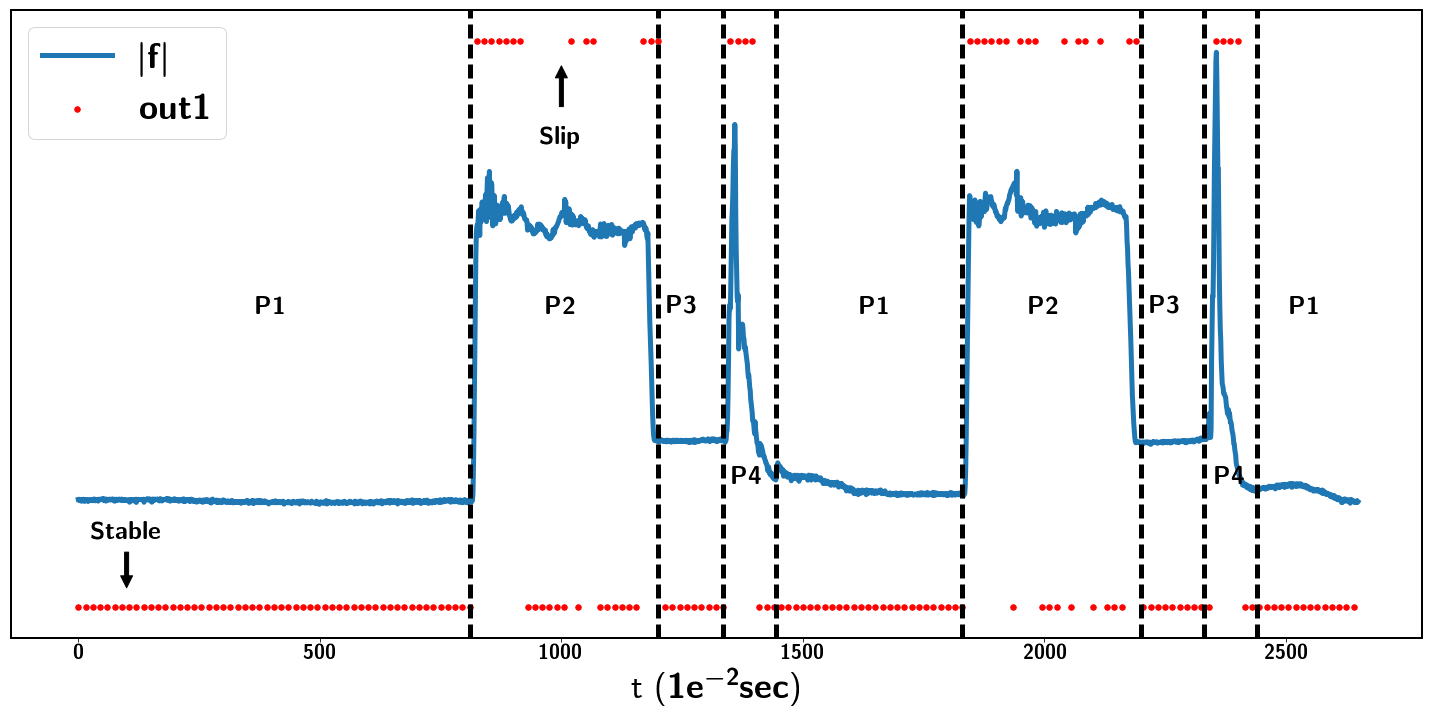

In [27]:
############ VISUALIZING ONLINE TESTING PROCEDURE ##############

subfeats = ['AFFT','FREQ','TIME','BOTH']
feats = ['fnorm','ftfn','fnormftfn']
matplotlib.rcParams['text.usetex'] = True

fileid = filename1(0,3,0,5)
fileidb = filename1(0,0,0,5)
fileid5 = filename5(0,3,0,1,2,3,4,5)
fileid5b = filename5(0,0,0,1,2,3,4,5)
model = np.load(fileid)['model'][0]
modelb = np.load(fileidb)['model'][0]
model5 = np.load(fileid5)['model'][0]
model5b = np.load(fileid5b)['model'][0]
Yout = model.predict(X[0])
Youtb = modelb.predict(Xsp[0][:,-window-2:-window/2-1])
Yout5 = model5.predict(Xsp[0])
Yout5b = model5b.predict(Xsp[0][:,-window-2:-window/2-1])
print Yout.shape, Yout5.shape, Yout5b.shape
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
offset = 2000-window
endset = 2650
skipf = 20
skipy = 15
ax = plt.figure(figsize=(20,10))
tf = np.linalg.norm(f[0][offset+window::skipf,:3][:endset],axis=1)
p1, = plt.plot(tf/max(tf),linewidth=5)
ty = Yout[offset/skipf:][:endset]+0.02
print tf.shape, ty.shape
p = plt.scatter(range(len(tf))[::skipy],ty[::skipy],color='red',s=30)
plt.hold
plt.text(100, 0.15, r'\textbf{Stable}', ha="center", va="center", rotation=0,
            size=25)
plt.text(1000, 0.85, r'\textbf{Slip}', ha="center", va="center", rotation=0,
            size=25)
plt.annotate('', fontsize=10, xy=(100, 0.05), xytext=(100, 0.12),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(1000, 0.98), xytext=(1000, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.text(400, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=810,linestyle='dashed',color='black',linewidth=5)
plt.text(1000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1200,linestyle='dashed',color='black',linewidth=5)
plt.text(1250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1335,linestyle='dashed',color='black',linewidth=5)
plt.text(1385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1445,linestyle='dashed',color='black',linewidth=5)
plt.text(1650, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1830,linestyle='dashed',color='black',linewidth=5)
plt.text(2000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2200,linestyle='dashed',color='black',linewidth=5)
plt.text(2250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2330,linestyle='dashed',color='black',linewidth=5)
plt.text(2385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2440,linestyle='dashed',color='black',linewidth=5)
plt.text(2540, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.xlabel(r't ($1e^{-2} sec$)',fontsize=35)
plt.yticks([])
plt.legend([p1,p],[r'$|\textbf{f}|$',r'\textbf{out1}'],loc=2, prop={'size': 35})
plt.tick_params(labelsize=20)
plt.tight_layout()
savefig('validation.pdf', bbox_inches='tight')
